This module will combine the dataframes from the previous two approaches. 
-TenFeatures
-NLP
Hopefully using features from both will improve the model.


In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

Below, a few cells importing both csvs and cleaning up. Finally, merging the two.

In [2]:
# import both csvs, some clean up
wiki_feat = pd.read_csv('../TenFeatures/wiki_10feat.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index

wiki_nlp = pd.read_csv('../NLP/wiki_nlp_small.csv')
wiki_nlp = wiki_nlp.rename(columns={'this_article_unique_name': 'article_name'})
wiki_nlp = wiki_nlp.set_index('article_name') #set article name as index
wiki_nlp = wiki_nlp.reset_index()
wiki_nlp.fillna(value = 0, inplace=True)

In [3]:
# clean up wiki_feat more
wiki_feat.drop(columns=['date_article_creation'], inplace=True) #unused
wiki_feat_columns = ['languages', 'references', 'text_length', 'main_article_num', 'see_also_num', 'table_text_len', 'sports', 'wiki_link_num', 'days_since_creation']
wiki_feat = wiki_feat.reindex(columns=wiki_feat_columns)
wiki_feat = wiki_feat.reset_index()
wiki_feat = wiki_feat.rename(columns={'languages': 'lang_total_num_targt','references': 'ref_total_num_feat','sports':'sports_bool'})

In [4]:
# clean up wiki_nlp more
wiki_nlp.drop(columns=['lang_total_num_target'], inplace=True) #deleting lang_total_num is important here since we don't want two 'languages' columns in the resulting df

In [5]:
#merge the two dataframes
wiki_comb = wiki_feat.merge(wiki_nlp, left_on='article_name', right_on='article_name')
wiki_comb = wiki_comb.reset_index()
wiki_comb.set_index('article_name', inplace=True) #set article name as index

Adding some more features and still cleaning up before modeling

In [6]:
# add interacting terms from the terms that were kept from lasso transformation with only the 10 features
wiki_comb['ref_total_num_feat * wiki_link_num'] = wiki_comb['ref_total_num_feat'] * wiki_comb['wiki_link_num']
wiki_comb['see_also_num * sports_bool'] = wiki_comb['see_also_num'] * wiki_comb['sports_bool']
wiki_comb['table_text_len * wiki_link_num'] = wiki_comb['table_text_len'] * wiki_comb['wiki_link_num']
wiki_comb['wiki_link_num^2'] = wiki_comb['wiki_link_num'] ** 2
wiki_comb = wiki_comb.reset_index()
wiki_comb.set_index('article_name', inplace=True) #set article name as index

In [7]:
#normalize all features except languages
normalized_wiki_comb = (wiki_comb - wiki_comb.mean()) / wiki_comb.std()
normalized_wiki_comb['lang_total_num_targt'] = wiki_comb['lang_total_num_targt']
normalized_wiki_comb.dropna(axis='columns',inplace=True)
normalized_wiki_comb.drop(columns = 'index',inplace=True,errors='ignore')

In [8]:
normalized_wiki_comb.head()

,lang_total_num_targt,ref_total_num_feat,text_length,main_article_num,see_also_num,table_text_len,sports_bool,wiki_link_num,days_since_creation,february,...,over,evangelical,tornado,mpc,jpl,socorro,ref_total_num_feat * wiki_link_num,see_also_num * sports_bool,table_text_len * wiki_link_num,wiki_link_num^2
article_name,,,,,,,,,,,,,,,,,,,,,
"Sérgio Pinto (footballer, born 1973)",1,-0.212821,-0.352448,-0.111103,-0.120394,-0.314144,2.870889,0.109592,0.421800,-0.097208,...,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591,-0.073691,-0.045402,-0.211350,-0.059904
Bradley Jennings,2,-0.003722,-0.297816,-0.111103,-0.120394,-0.229158,2.870889,-0.343437,-0.543322,-0.097208,...,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591,-0.060447,-0.045402,-0.192603,-0.178792
Progressive Canadian Party,1,-0.212821,0.622596,-0.111103,2.269721,0.517745,-0.348228,0.158131,1.481108,-0.097208,...,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591,-0.072828,-0.045402,0.238296,-0.044922
2-Heptanone,11,0.623574,0.083659,-0.111103,-0.120394,-0.154376,-0.348228,-0.036024,0.674127,-0.097208,...,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591,0.030826,-0.045402,-0.139456,-0.102243
Michael Yano,20,-0.282520,-0.399591,-0.111103,-0.120394,-0.269214,2.870889,0.174310,0.189240,-0.097208,...,-0.019073,-0.023508,-0.01976,-0.016591,-0.016591,-0.016591,-0.082713,-0.045402,-0.184980,-0.039832


Modeling finally!

In [9]:
X = normalized_wiki_comb.loc[:, 'ref_total_num_feat':"wiki_link_num^2"]
y = normalized_wiki_comb['lang_total_num_targt']

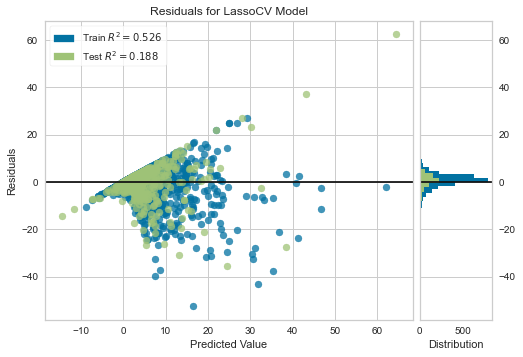

In [10]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Instantiate the linear model and visualizer
model = LassoCV()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

MAE and MRSE


In [13]:
#mae of training set
mae = metrics.mean_absolute_error(y_train, model.predict(X_train))
print(mae)

3.131726073968269


In [14]:
#mae of test set
mae = metrics.mean_absolute_error(y_test, model.predict(X_test))
print(mae)

3.475247096098467


In [15]:
#mrse of training set
mrse = metrics.mean_squared_error(y_train, model.predict(X_train))
print(mrse)

27.347671400370324


In [16]:
#mrse of test set
mrse = metrics.mean_squared_error(y_test, model.predict(X_test))
print(mrse)

36.83414252852904
